<a href="https://colab.research.google.com/github/dauparas/pytorch_examples/blob/master/vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Inspiration from https://github.com/rasbt/deeplearning-models/blob/master/pytorch_ipynb/autoencoder/ae-basic.ipynb

This VAE does not produce good examples...

In [0]:
import time
from numbers import Number
import numpy as np
import torch
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [0]:
batch_size = 256
random_seed = 0

In [4]:
train_dataset = datasets.MNIST(root='data', 
                               train=True, 
                               transform=transforms.ToTensor(),
                               download=True)

test_dataset = datasets.MNIST(root='data', 
                              train=False, 
                              transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True, num_workers=1, pin_memory=torch.cuda.is_available())

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False, num_workers=1, pin_memory=torch.cuda.is_available())

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Image batch dimensions: torch.Size([256, 1, 28, 28])
Image label dimensions: torch.Size([256])


In [0]:
class Encoder(nn.Module):
  def __init__(self, input_size, latent_size):
    super(Encoder, self).__init__()

    self.lin1 = nn.Linear(input_size, 256)
    self.lin2 = nn.Linear(256, 128)
    self.lin3 = nn.Linear(128, 64)
    self.lin_mu = nn.Linear(64, latent_size)
    self.lin_logvar = nn.Linear(64, latent_size)

  def forward(self, x):
    h = F.elu(self.lin1(x))
    h = F.elu(self.lin2(h))
    h = F.elu(self.lin3(h))
    mu = self.lin_mu(h)
    logvar = self.lin_logvar(h)
    # logvar = 0.0*torch.ones_like(mu)

    return mu, logvar

class Decoder(nn.Module):
  def __init__(self, latent_size, output_size):
    super(Decoder, self).__init__()

    self.lin1 = nn.Linear(latent_size, 64)
    self.lin2 = nn.Linear(64, 128)
    self.lin3 = nn.Linear(128, 256)
    self.lin4 = nn.Linear(256, output_size)
  
  def forward(self, x):
    h = F.elu(self.lin1(x))
    h = F.elu(self.lin2(h))
    h = F.elu(self.lin3(h))
    h = self.lin4(h)
    return h

class VAE(nn.Module):
  def __init__(self, encoder, decoder, device):
    super(VAE, self).__init__()

    self.encoder = encoder
    self.decoder = decoder


  def reparameterize(self, z_mu, z_logvar):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(device)
        z = z_mu + eps * torch.exp(z_logvar/2.) 
        return z

  def forward(self, x):
    z_mean, z_logvar = self.encoder(x)
    z_sample = self.reparameterize(z_mean, z_logvar)
    out = self.decoder(z_sample)
    return z_mean, z_logvar, z_sample, out

In [0]:
torch.manual_seed(random_seed)
encoder = Encoder(input_size=28*28, latent_size=16)
decoder = Decoder(latent_size=16, output_size=28*28)
vae = VAE(encoder, decoder, device=device)
vae.to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=3e-4)

In [7]:
device

device(type='cuda', index=0)

In [8]:
%%time
num_epochs = 10
count = 0
for epoch in range(num_epochs):
    for batch_idx, (features, _) in enumerate(train_loader):
        count+=1
        # don't need labels, only the images (features)
        features = features.view(-1, 28*28).to(device)
            
        ### FORWARD AND BACK PROP
        z_mean, z_logvar, z_sample, out = vae(features)
        recon_loss = F.binary_cross_entropy(out.to(device), features)
        kl_divergence = (0.5 * (z_mean**2 + 
                                torch.exp(z_logvar) - z_logvar - 1)).sum()

        beta = 0.5
        loss = recon_loss + beta*kl_divergence

        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        ### LOGGING
        if not batch_idx % 70:
            print ('Epoch: %03d/%03d | Batch %03d/%03d | Loss: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), loss))

Epoch: 001/010 | Batch 000/235 | Loss: nan
Epoch: 001/010 | Batch 070/235 | Loss: nan
Epoch: 001/010 | Batch 140/235 | Loss: nan
Epoch: 001/010 | Batch 210/235 | Loss: 2357.1179
Epoch: 002/010 | Batch 000/235 | Loss: nan
Epoch: 002/010 | Batch 070/235 | Loss: nan
Epoch: 002/010 | Batch 140/235 | Loss: nan
Epoch: 002/010 | Batch 210/235 | Loss: nan
Epoch: 003/010 | Batch 000/235 | Loss: nan
Epoch: 003/010 | Batch 070/235 | Loss: 2467.2915
Epoch: 003/010 | Batch 140/235 | Loss: 2316.5403
Epoch: 003/010 | Batch 210/235 | Loss: nan
Epoch: 004/010 | Batch 000/235 | Loss: 2357.3989
Epoch: 004/010 | Batch 070/235 | Loss: 2316.4246
Epoch: 004/010 | Batch 140/235 | Loss: 2411.7175
Epoch: 004/010 | Batch 210/235 | Loss: 2354.7107
Epoch: 005/010 | Batch 000/235 | Loss: 2313.5356
Epoch: 005/010 | Batch 070/235 | Loss: nan
Epoch: 005/010 | Batch 140/235 | Loss: 2427.1218
Epoch: 005/010 | Batch 210/235 | Loss: 2358.9458
Epoch: 006/010 | Batch 000/235 | Loss: 2441.0842
Epoch: 006/010 | Batch 070/235 

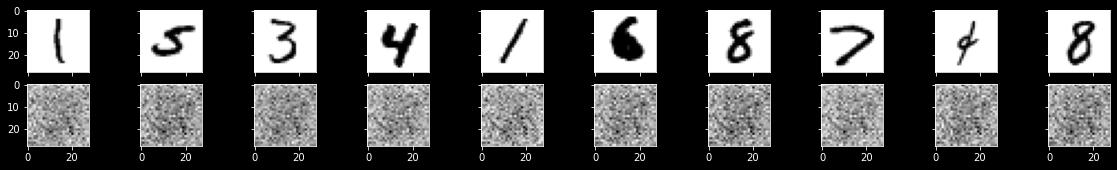

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('dark_background')


n_images = 10
image_width = 28

fig, axes = plt.subplots(nrows=2, ncols=n_images, 
                         sharex=True, sharey=True, figsize=(20, 2.5))
orig_images = features[:n_images]
decoded_images = out[:n_images]

for i in range(n_images):
    for ax, img in zip(axes, [orig_images, decoded_images]):
        curr_img = img[i].detach().to(torch.device('cpu'))
        ax[i].imshow(curr_img.view((image_width, image_width)), cmap='binary')